# 1. Experiment 1: 
"find parameters for synthetic observation(s) reserved from the trained surrogate model with a defined degree of randomness"
1. Build Surrogate of ParFlow streamflow, `lstm_A`
2. Construct amortized (full) P(`theta | q_surr_all`) via a Neural Density Estimator, or `NDE`
3. Sample posterior, P(`theta | q_surr_all = q_surr_obs`)
4. Interpretive Plots

##### --------
* Steps 1, 2 and embedded in the `lstm_sbi.py` 'run' script
* steps 3, 4 are shown below. 
* See `/home/qh8373/SBI_TAYLOR/sbi_taylor/psuedocode-sbi-experiments.md` for full details about the experiment

* NOTES:
    * Many Workflows Taken from:
        * `AGU_Synthesis.ipynb`
        * `SBI_Interp_Agg.ipynb`
        * `test_lstm_sbi.ipynb`

In [29]:
import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime
from copy import copy
from copy import deepcopy
import pickle

from parflowio.pyParflowio import PFData

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import glob


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# -- Libararies  
import os
import sys
import pickle
import torch
from random import *

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate

# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

# user defined functions
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from genutils import PFread, plot_stuff
from ensembleutils import assembleYears, assembleAllForcings, parseAllMetadata, returnDF_ens, returnAOC_ens, _ret_MinMax, _ret_AOCMinMax
from assessutils import compute_stats
from scalerutils import scaled_ens_Values, scaledForcingData, scaledAOCData
from posteriorsamputils import statTheta, genProbThetas, gen_Fit_Series_Wrapper
from summaryutils import summary, setStatSim
from sbiutils import retStatTyp, parseListDf, parseUniqueParams
from sbiutils import reshape_y, createYHatList, createYHat, setNoise
from interputils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import LogNorm, Normalize
import matplotlib.tri as tri
import pickle
import sys
import torch

import spotpy
import spotpy.objectivefunctions as obj_mets

import scipy
from scipy.spatial import distance

## 3. Sample posterior, P(`theta | q_surr_all = q_surr_obs`)
* Default routine samples each posterior just once

## 4. Interpretive Plots

### Loading SBI Posteriors

In [2]:
# Directories
sbi_run  = '0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'
print(save_dir)

lstm_name = '02_05_lstm_A'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate/


### a. Interpretive plots for each synthetic observations, parameters only

#### Selection Criteria and Load Posterior

In [3]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 1 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

#### General loading for posterior sampling

In [4]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]

#### Sample Posterior (Emulated)

Time to run one LSTM  0:00:00.003346


/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-5-03c7aa276a29>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



Time to sample SNPE  0:00:00.047364
the theta value is tensor([0.5995, 0.8495]) 

Emulated


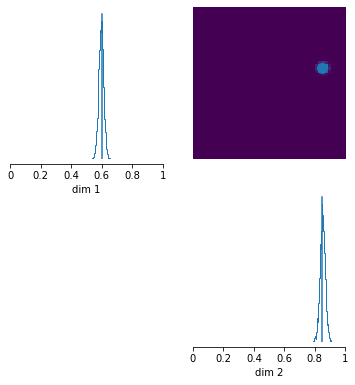

In [5]:
# emulated streamflow

y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))

start = datetime.now()
simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx])
print("Time to run one LSTM ", datetime.now() - start)

y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)

'''
sample posterior and create log probability
'''
# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
start = datetime.now()
posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
print("Time to sample SNPE ", datetime.now() - start)
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.eps', format='eps')

plt.show()

#### Sample Posterior (Emulated - Zoom)

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-6-bd2d2abf7575>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



the theta value is tensor([0.5995, 0.8495]) 

Emulated


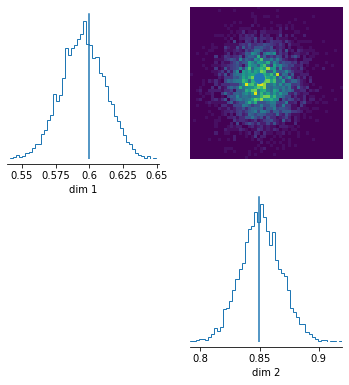

In [6]:
# emulated streamflow
y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)

'''
sample posterior and create log probability
'''
# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples = posterior.sample((n_samples,), x=y_hat) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability = posterior.log_prob(posterior_samples, x=y_hat).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples, 
                               points=torch.tensor(true_theta),
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_zoom.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_zoom.eps', format='eps')

plt.show()

#### Covariance Matrix and Determinant

In [7]:
# get covariance matrix
post_cov = np.cov(posterior_samples.T)
print('covariance matrix is...')
print(post_cov)

# get determinant
det = np.linalg.det(post_cov)
print('\n determinant of covariance matrix is...')
print(det)

# get mahalanobis distance
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html
# https://en.wikipedia.org/wiki/Mahalanobis_distance
# note, using the test data taken from earlier, class 0, a single point
true_th = np.array(true_theta)
# extract average for later
mean_th = np.array(posterior_samples.mean(axis=0))
# invert covariance for later
post_cov_inv = np.linalg.inv(post_cov)

print('\n True theta', true_th)
print('Mean theta', mean_th)
print('Inverse Covariance', post_cov_inv)

print("\n Man - distance, scipy routine")
dist = distance.mahalanobis(true_th,mean_th,post_cov_inv)
print(dist)

print('\n Euclidian Distance')
eu_dist = np.sqrt( (true_th[0] - mean_th[0])**2 + (true_th[1] - mean_th[1])**2)
eu_dist_norm = np.sqrt( (true_th[0] - mean_th[0])**2/post_cov[0,0] + (true_th[1] - mean_th[1])**2/post_cov[1,1])
print(eu_dist)
print(eu_dist_norm)

covariance matrix is...
[[2.77174568e-04 1.50439968e-06]
 [1.50439968e-06 2.99659193e-04]]

 determinant of covariance matrix is...
8.305564410775639e-08

 True theta [0.599485 0.849485]
Mean theta [0.5952618 0.8510819]
Inverse Covariance [[3607.93292598  -18.11315407]
 [ -18.11315407 3337.21531849]]

 Man - distance, scipy routine
0.27037533308698053

 Euclidian Distance
0.00451501107158131
0.2699194728665385


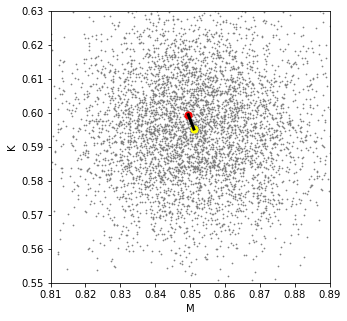

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(posterior_samples[:,1], posterior_samples[:,0], s=0.5, c='grey', label='all potential params')
plt.scatter(true_th[1],true_th[0], s=50, c='red', label='true value')
plt.scatter(mean_th[1],mean_th[0], s=50, c='yellow', label='true value')
plt.plot([true_th[1], mean_th[1]], [true_th[0], mean_th[0]],color='black',linewidth=3)
plt.xlabel('M')
plt.ylabel('K')
plt.xlim(0.81,0.89)
plt.ylim(0.55,0.63)

fig.savefig(f'{save_dir}scatter_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_zoom_simp.png')
fig.savefig(f'{save_dir}scatter_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_zoom_simp.eps', format='eps')

plt.show()



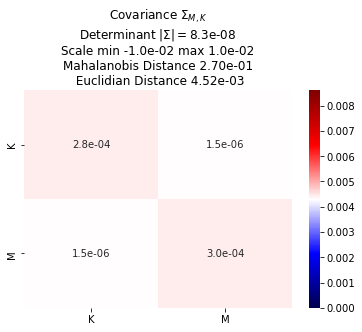

In [9]:
# vmin and max, in an ideal world
vm, vma = -1e-2, 1e-2 #-np.max(np.abs(post_cov)), np.max(np.abs(post_cov)) # (-1e-2, 1e-2)

# normalize for negatives (https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html)
b = 1
a = b - vm

log_post_cov = np.log10(post_cov + a)

# subtract from minimum for log-scale plottage
vm_pl, vma_pl = np.log10(vm+a), np.log10(vma+a)

fig, ax = plt.subplots()

# heat map
sns.heatmap(log_post_cov, vmin=vm_pl, vmax=vma_pl, cmap='seismic',
           xticklabels=['K', 'M'], yticklabels=['K','M'], annot=post_cov, fmt='.1e')
plt.title(r'Covariance $\Sigma_{M,K}$'+'\n'+r'Determinant $|\Sigma| = $'+f'{det:.1e}'+'\n'+f'Scale min {vm:.1e} max {vma:.1e}''\n'+f'Mahalanobis Distance {dist:.2e}'+ f'\n Euclidian Distance {eu_dist:.2e}')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}cov_mat_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated.eps', format='eps')
plt.show()


#### Sample Posterior (ParFlow)
* nb: to check for bias

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


<ipython-input-12-18ac4baa3a69>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=torch.tensor(true_theta),



tensor(0.8821)
the theta value is tensor([0.5995, 0.8495]) 

PARFLOW


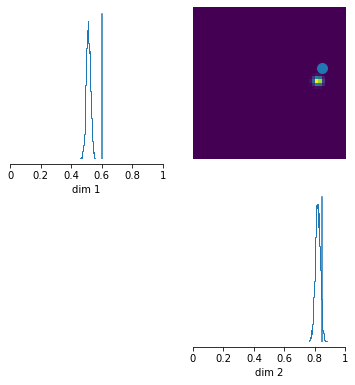

In [12]:
# PF
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method='full', stat_typ=None, embed_type=None)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]

'''
sample posterior and create log probability
'''
# PF
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_PF = posterior.sample((n_samples,), x=y_hat_PF) # type - tensor object
# posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
log_probability_PF = posterior.log_prob(posterior_samples_PF, x=y_hat_PF).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('PARFLOW')
fig, ax = analysis.pairplot(posterior_samples_PF, 
                               points=torch.tensor(true_theta),
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_PF.eps', format='eps')

plt.show()



### b. Interpretive plots for each synthetic observations, streamflow timeseries only

#### Bootstrap + Get Truth (Emulated)

In [14]:
'''
bootstrap
'''
# emulated
boots_params, boots_logprob, idxs = randBootstrap(posterior_samples, log_probability)

'''
get 'truth'
'''
# emulated
y_hat_plot = y_hat_full.T.detach().numpy()
y_len = len(y_hat_plot)

#### Run Forward Simulations (emulators)

In [60]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)


Caution, multiple emulators available
tensor(0.5375, dtype=torch.float64)


tensor(0.5341, dtype=torch.float64)

#### Plot time series (emulators)

emulated


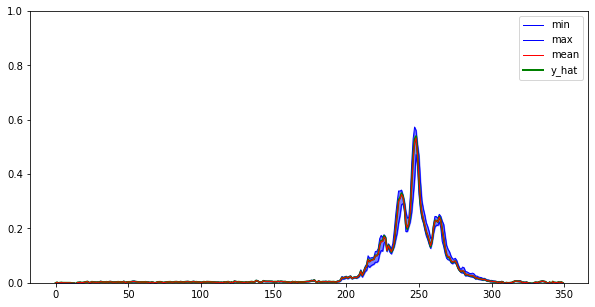

In [13]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated.eps', format='eps')
plt.show()


#### Plot time series (Zoom-emulators)

emulated


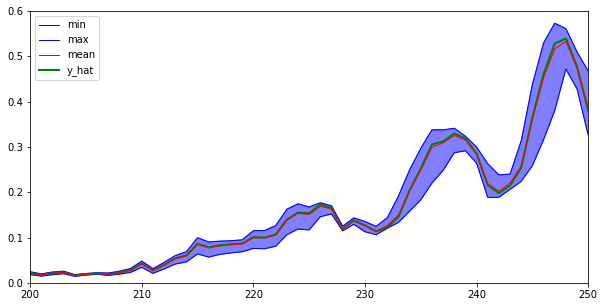

In [14]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,0.6)
ax.set_xlim(200,250)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_zoom.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_zoom.eps', format='eps')
plt.show()


#### Generate true simulations (param_1) - for metrics

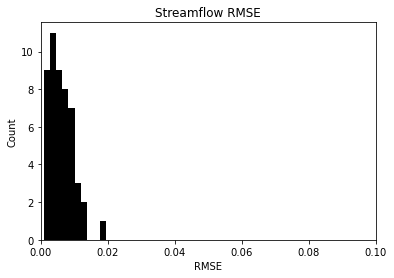

0.005960248387451209 Mean of the RMSE
0.00362340945913207 Standard Deviation of the RMSE


In [15]:
rmse_arr = np.empty(y_sims.shape[0])
xi = 0
for sim in y_sims:
    rmse_arr[xi] = obj_mets.rmse(y_hat_plot[:,0], sim)
    xi += 1

fig, ax = plt.subplots()
    
# help(plt.hist)
plt.hist(rmse_arr, color='black', density=False, bins=10)
plt.xlim(0,0.1)
plt.title('Streamflow RMSE')
plt.ylabel('Count')
plt.xlabel('RMSE')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_emulated.png')
fig.savefig(f'{save_dir}histogram_streamflow_series_{sub}_runidx_{idx}_emulated.eps', format='eps')
plt.show()

print(rmse_arr.mean(), 'Mean of the RMSE')
print(rmse_arr.std(), 'Standard Deviation of the RMSE')

#### Bootstrap + Get Truth (ParFlow)

In [16]:
'''
bootstrap
'''
# PARFLOW
boots_params_PF, boots_logprob_PF, idxs_PF = randBootstrap(posterior_samples_PF, log_probability_PF)

'''
get 'truth'
'''
# PARFLOW
y_hat_plot_PF = y_hat_full_PF.T.detach().numpy()
y_len = len(y_hat_plot_PF)


#### Run Forward Simulations (ParFlow)

In [17]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list,
                          add_noise=True,f_noise=1e-02, lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (ParFlow)

Parflow


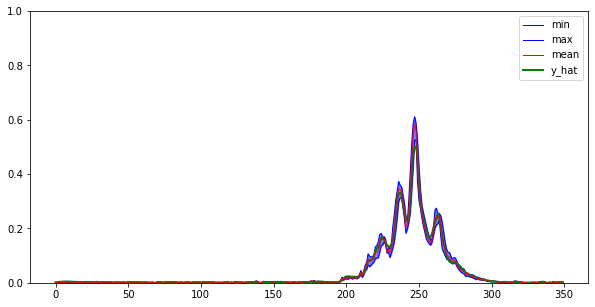

In [18]:
# PARFLOW
print('Parflow')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims_PF.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims_PF.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_PF.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims_PF.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot_PF, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims_PF.T.min(axis=1), y_sims_PF.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_PF.eps', format='eps')
plt.show()

### c. Interpretive plots for alls synthetic observations, parameters only

#### Some Control Parameters

In [19]:
sub_sub_num = 100
save_bool = True
trueflow = True
true_flow_idx = 82
stats_bool = True
stat_typ = np.array([4, 12, 13])

#### Get data to plot on 2D

In [27]:
out = getData_Surface(save_dir, sbi_dir, sub, sub_sub_num, stats_bool=stats_bool,
                      stat_typ=stat_typ, scaled_bool=True, save_bool=True)

In [30]:
print(out.keys())
print(out['stat_arr'][:,1].max())

dict_keys(['param_arr', 'euc_arr', 'dist_arr', 'det_arr', 'nse_arr', 'prob_arr', 'stat_arr'])
0.2655220627784729


#### Plot on 2D surface

In [ ]:
# plottage
ngrid = 50
levels = 10

cmap = "RdBu" #__r
param_arr = out['param_arr']
cmap_list = ["RdBu_r", "RdBu_r", "RdBu", "RdBu_r", "RdBu_r", "RdBu" , "RdBu_r", "RdBu_r", "RdBu_r"]
norm_list = [True, True, False, True, True, False, False, False, False]
z_name_list = ['euclidean', 'determinant', 'nse', 'dist_param1', 'dist_param2',
                'log_prob', f'stat_typ{stat_typ[0]}', f'stat_typ{stat_typ[1]}', f'stat_typ{stat_typ[2]}']

z_arr_list = [out['euc_arr'], out['det_arr'], out['nse_arr'], out['dist_arr'][:,0], out['dist_arr'][:,1], 
              out['prob_arr'], out['stat_arr'][:,0], out['stat_arr'][:,1], out['stat_arr'][:,2]]

levels_list = {'determinant' : np.exp(np.linspace(np.log(1e-8),np.log(1e-5),levels)), 
               'dist_param1' : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'dist_param2' : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'euclidean'   : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)), 
               'log_prob'    : np.linspace(0,6,levels),
               'nse'         : np.linspace(0,1,levels),
               f'stat_typ{stat_typ[0]}' : np.linspace(210,250,levels), # np.linspace(0.04,0.14,levels)
               f'stat_typ{stat_typ[1]}' : np.linspace(0.16,0.24,levels), # np.linspace(0.42,0.96,levels)
               f'stat_typ{stat_typ[2]}' : np.linspace(0.01,0.1,levels) # np.linspace(259,266,levels)
              }

plt.rc('font', size=12)

for idx_out in range(len(z_arr_list)):
    z_name = z_name_list[idx_out]
    if levels_list is None:
        levels_arr = levels
    else:
        levels_arr = levels_list[z_name]
    gen_2D_surface(z_name, z_arr_list[idx_out], param_arr, 
                   save_dir, sub, trueflow=trueflow, true_flow_idx=true_flow_idx, 
                   ngrid=ngrid, levels=levels_arr, norm_bool=norm_list[idx_out], cmap=cmap_list[idx_out], save_bool=True)

### d. Interpretive plots for all synthetic observations, streamflow only

KeyboardInterrupt: 

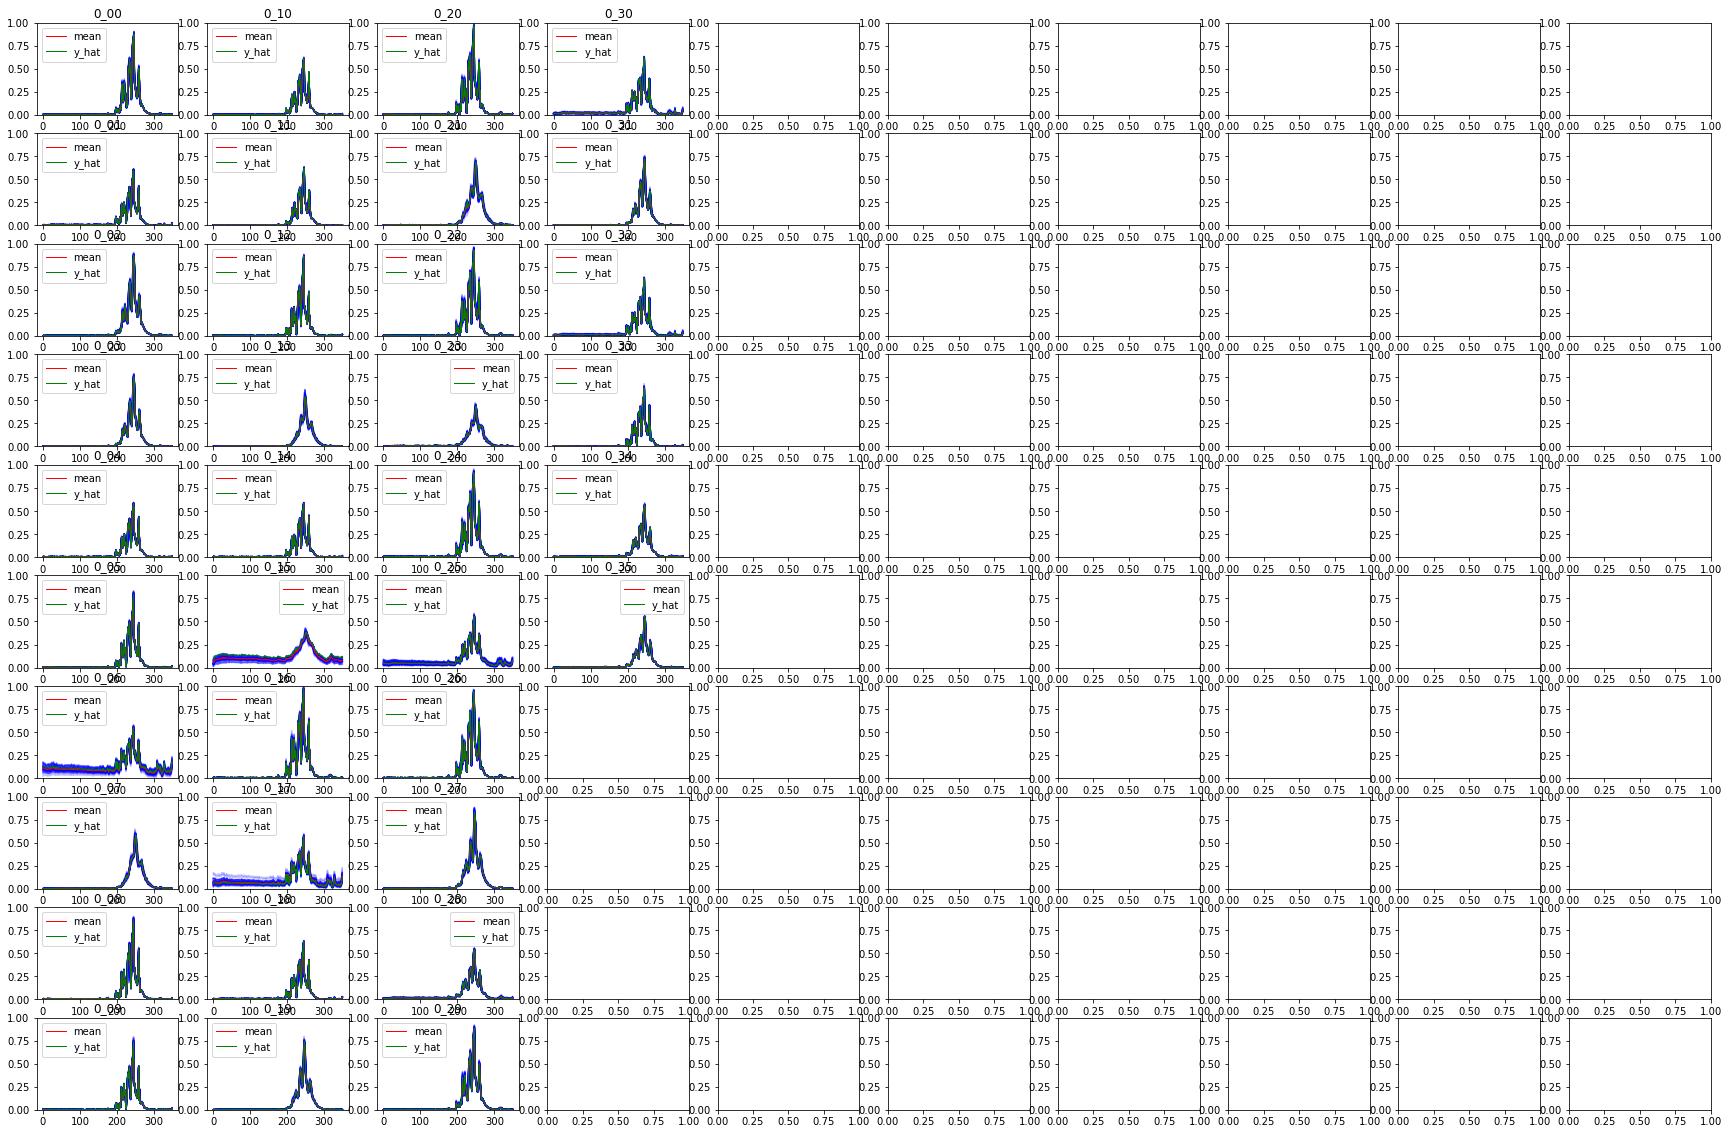

In [14]:
# for plotting
dim1, dim2 = 10, 10


plt.rc('font', size=10)

plot_hydrograph(save_dir, sbi_dir, sub, sub_sub_num, dim1, dim2, 
                trueflow, true_flow_idx, scaled_bool=True, save_bool=True, 
                add_noise=True, f_noise=1e-02)

## create another pair plot for analysis in Multiple Plot Experiment

### pt1

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)



the theta value is tensor([0.5995, 0.8495]) 

Emulated


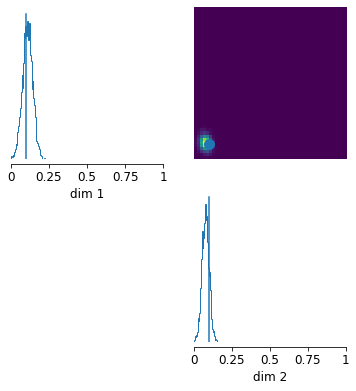

In [83]:
pt1_pl = torch.tensor([0.1,0.1])

y_hat_full_pt1_pl = reshape_y(simulate(DataX=DataX_test, theta=pt1_pl, lstm=lstm_out_list[lstm_idx]))
# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_pt1_pl = posterior.sample((n_samples,), x=y_hat_full_pt1_pl) # type - tensor object
log_probability_pt1_pl = posterior.log_prob(posterior_samples_pt1_pl, x=y_hat_full_pt1_pl).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples_pt1_pl, 
                               points=pt1_pl,
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_multiplt_pt1_pl.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_multiplt_pt1_pl.eps', format='eps')

plt.show()


#### Bootstrap + Get Truth (Emulated)

In [91]:
'''
bootstrap
'''
# emulated
boots_params, boots_logprob, idxs = randBootstrap(posterior_samples_pt1_pl, log_probability_pt1_pl)

'''
get 'truth'
'''
# emulated
y_hat_plot = y_hat_full_pt1_pl.T.detach().numpy()
y_len = len(y_hat_plot)

#### Run Forward Simulations (emulators)

In [92]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (emulators)

emulated


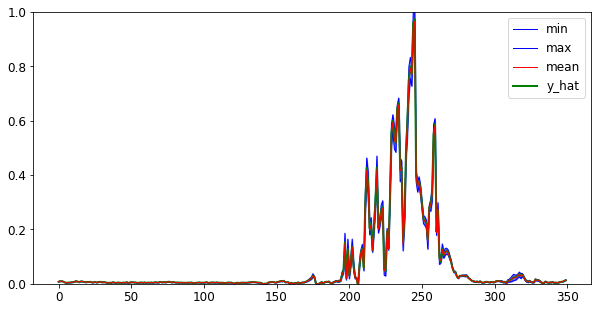

In [93]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_multiplt_pt1_pl.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_multiplt_pt1_pl.eps', format='eps')
plt.show()


### pt2

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)



the theta value is tensor([0.5995, 0.8495]) 

Emulated


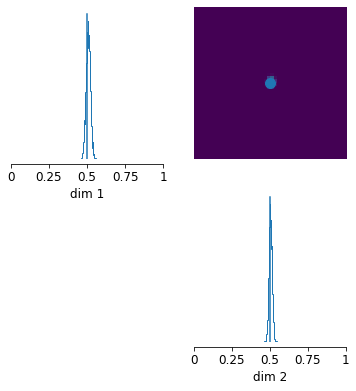

In [94]:
pt2_pl = torch.tensor([0.5,0.5])

y_hat_full_pt2_pl = reshape_y(simulate(DataX=DataX_test, theta=pt2_pl, lstm=lstm_out_list[lstm_idx]))

# emulated
# - given observation(s), sample posterior, evaluate probability, and plot
posterior_samples_pt2_pl = posterior.sample((n_samples,), x=y_hat_full_pt2_pl) # type - tensor object
log_probability_pt2_pl = posterior.log_prob(posterior_samples_pt2_pl, x=y_hat_full_pt2_pl).unsqueeze(1) # type - tensor object

'''
Pairplot
'''
print('the theta value is', true_theta, '\n')

print('Emulated')
fig, ax = analysis.pairplot(posterior_samples_pt2_pl, 
                               points=pt2_pl,
                               limits=[[0, 1],[0, 1]], 
                               figsize=(6,6)) # 
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_multiplt_pt2_pl.png')
fig.savefig(f'{save_dir}pair_plot_lstmidx_{lstm_idx}_sub_{sub}_runidx_{idx}_emulated_multiplt_pt2_pl.eps', format='eps')

plt.show()


#### Bootstrap + Get Truth (Emulated)

In [105]:
'''
bootstrap
'''
# emulated
boots_params, boots_logprob, idxs = randBootstrap(posterior_samples_pt2_pl, log_probability_pt2_pl)

'''
get 'truth'
'''
# emulated
y_hat_plot = y_hat_full_pt2_pl.T.detach().numpy()
y_len = len(y_hat_plot)

#### Run Forward Simulations (emulators)

In [112]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims = genSimulation(DataX_test, boots_params, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



Caution, multiple emulators available


#### Plot time series (emulators)

emulated


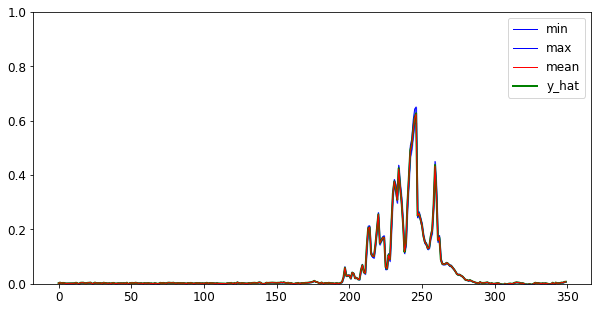

In [113]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

# emulated
print('emulated')
fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_multiplt_pt2_pl.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_runidx_{idx}_emulated_multiplt_pt2_pl.eps', format='eps')
plt.show()


## 2D x2

In [20]:
out_test = grabDataarrays(sbi_dir, sub, sub_sub_int=0)
test_params = out_test[1]
lstm_out_list = out_test[2]
DataX_test = out_test[0]
num_rep = 50
num_sample = 21

# a uniformly sampled array, from https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
uni_param = np.linspace(0,1,num_sample)
forward_params = np.array(np.meshgrid(uni_param, uni_param)).T.reshape(-1,2)
forward_params = torch.tensor(forward_params)

# storage array
store_arr = torch.empty((len(forward_params), 5))

# generate forward simulations
y_2D = genSimulation(DataX_test, forward_params, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)

### generate simulations across entire space

In [21]:
# loop trough an array of parameter sets, uniformly sampled, for each:
for limi in range(len(forward_params)):
    # sample parameters
    param_temp = forward_params[limi,:]
    # generate simulation
    y_temp = y_2D[limi,:]
    # infer parameters
    post_temp = posterior.sample((n_samples,), x=y_temp, show_progress_bars=False)
    log_prob_temp = posterior.log_prob(post_temp, x=y_temp).unsqueeze(1) 
    
    # bootstrap
    boots_temp, boots_logprob_temp, idxs_temp = randBootstrap(post_temp, log_prob_temp)

    # generate bootstrap
    y_boots_temp = genSimulation(DataX_test, boots_temp, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)
    
    # generate metric array
        # (RMSE is 12)
    metric_arr = torch.empty((y_boots_temp.shape[0],17)) # this is storing everything for obj_mets.calcualte_all_functions
    h = 0
    for h in range(len(y_boots_temp)):
        y_test_temp = y_boots_temp[h,:]
        met_temp = torch.tensor(np.array(obj_mets.calculate_all_functions(y_temp,y_test_temp))[:,1].astype(float))
        metric_arr[h,:] = met_temp
        h = h + 1
        del met_temp, y_test_temp
    
    # calculate RMSE and STD
    rmse_m_temp = metric_arr[:,12].mean()
    rmse_std_temp = metric_arr[:,12].std()

    # calculate determinant
    cov_temp = np.cov(post_temp.T)
    det_temp = np.linalg.det(cov_temp)
    # get distance
    cov_inv_temp = np.linalg.inv(cov_temp)
    mean_temp = np.array(post_temp.mean(axis=0))
    dist_temp = distance.mahalanobis(param_temp,mean_temp,cov_inv_temp)
    eu_dist_temp = np.sqrt( (param_temp[0] - mean_temp[0])**2 + (param_temp[1] - mean_temp[1])**2)

    store_arr[limi, :] = torch.tensor([det_temp, dist_temp, eu_dist_temp, rmse_m_temp, rmse_std_temp])
    
    del y_temp, param_temp, post_temp, log_prob_temp
    del boots_temp, boots_logprob_temp, idxs_temp, y_boots_temp, metric_arr, h, rmse_m_temp, rmse_std_temp
    del cov_temp, det_temp, cov_inv_temp, mean_temp, dist_temp, eu_dist_temp
    
    # for later maybe?
    # generate simulations
    # calculate summaries
    # calculate metric

/home/qh8373/.local/lib/python3.8/site-packages/spotpy/objectivefunctions.py:128: RuntimeWarning: invalid value encountered in log
  return float(1 - sum((np.log(s) - np.log(e))**2) / sum((np.log(e) - np.mean(np.log(e)))**2))


In [28]:
print('determinant')
print(store_arr[:,1].min())

determinant
tensor(0.0253)


### plot zs

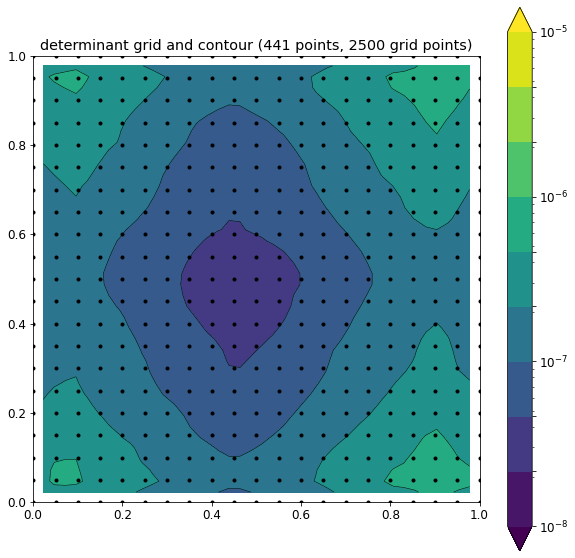

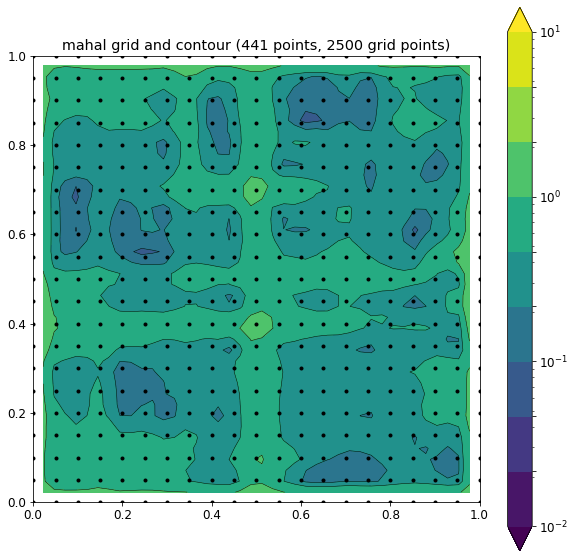

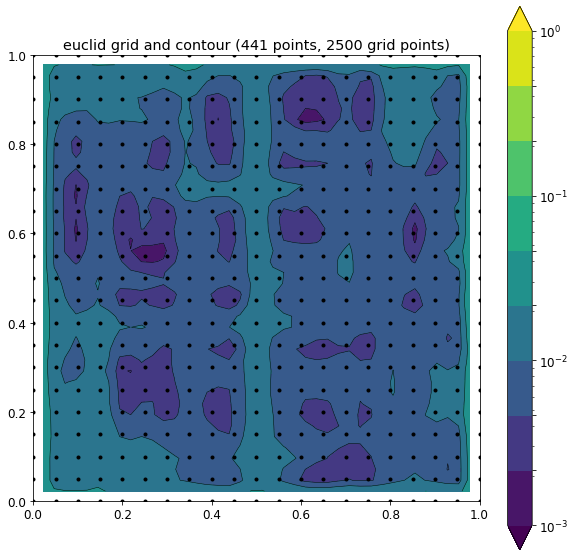

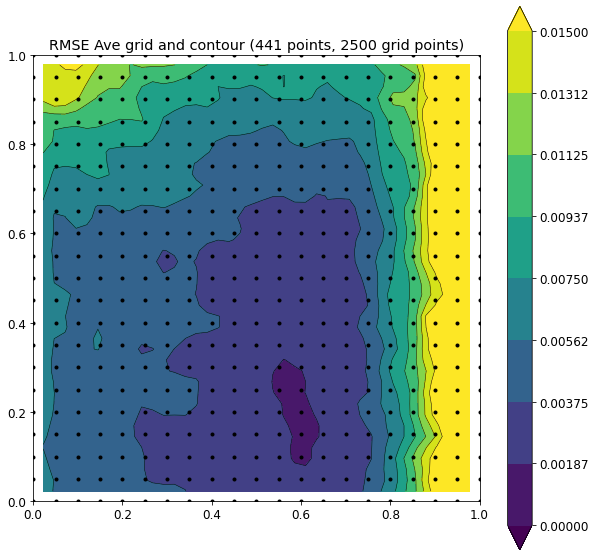

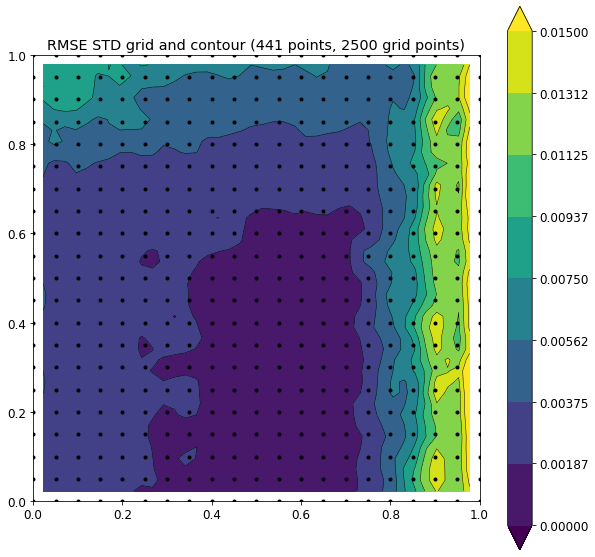

In [24]:
# plottage
ngrid = 50
levels = 10

cmap = "RdBu" #__r
param_arr = forward_params
cmap_list = ["viridis", "viridis", "viridis", "viridis", "viridis"] # RdBu_r
norm_list = [True, True, True, False, False] 
z_name_list = ['determinant', 'mahal', 'euclid', 'RMSE Ave', 'RMSE STD']

z_arr_list = [store_arr[:,0], store_arr[:,1], store_arr[:,2], store_arr[:,3], store_arr[:,4]]

levels_list = {'determinant' : np.exp(np.linspace(np.log(1e-8),np.log(1e-5),levels)), 
               'mahal'       : np.exp(np.linspace(np.log(1e-2),np.log(1e1),levels)),
               'euclid'   : np.exp(np.linspace(np.log(1e-3),np.log(1e-0),levels)),
               'RMSE Ave'   : np.linspace(0,0.015,9),
               'RMSE STD'   : np.linspace(0,0.015,9)
              }

plt.rc('font', size=12)

for idx_out in range(len(z_arr_list)):
    z_name = z_name_list[idx_out]
    if levels_list is None:
        levels_arr = levels
    else:
        levels_arr = levels_list[z_name]
    gen_2D_surface(z_name, z_arr_list[idx_out], forward_params, 
                   save_dir, sub, trueflow=False, true_flow_idx=0, 
                   ngrid=ngrid, levels=levels_arr, norm_bool=norm_list[idx_out], cmap=cmap_list[idx_out], save_bool=True)

## Follow-on Interpretive Plots - Updated 02202022

In [34]:
out_test = grabDataarrays(sbi_dir, sub, sub_sub_int=0)
test_params = out_test[1]
lstm_out_list = out_test[2]
DataX_test = out_test[0]
num_rep = 50
num_sample = 21

# a uniformly sampled array, from https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
uni_param = np.linspace(0,1,num_sample)
forward_params = np.array(np.meshgrid(uni_param, uni_param)).T.reshape(-1,2)
forward_params = torch.tensor(forward_params)
# subset of params
params_2 = forward_params[forward_params[:,0]==0.5].repeat(num_rep,1) # holding K constant, varying M
params_1 = forward_params[forward_params[:,1]==0.5].repeat(num_rep,1) # holding M constant, varying K

#### Scaled Stuff

In [35]:
# Taken from - https://verde.princeton.edu/pun/sys/dashboard/files/fs//home/qh8373/SBI_TAYLOR/data/03_ensemble_out/_ensemble_0819_01_mod2/scale_info.txt
Q_min, Q_max = 0.0, 8499.45168720763
AOC1_Min, AOC1_Max = -3.0, 1.0 # K
AOC2_Min, AOC2_Max = -8.0, -4.0 # Mannings

#### Stat Sim

In [36]:
# Taken from - https://verde.princeton.edu/pun/sys/dashboard/files/fs//home/qh8373/SBI_TAYLOR/data/03_ensemble_out/_ensemble_0819_01_mod2/scale_info.txt
stat_typ = np.array((4, 12, 13))

### Show the Space of Possibilities

#### Run Forward Simulations from forward params

In [37]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')
    

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims = genSimulation(DataX_test, forward_params, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



#### Plot time series (from forward params)

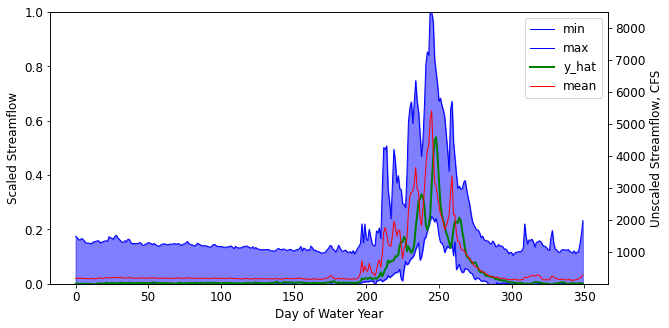

In [38]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

# ax.plot(y_sims.T, color='blue', alpha=0.25, zorder=0)# , label='y_sims')
ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_full_space_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_full_space_emulated.eps', format='eps')
plt.show()


#### Plot time series (from forward params)

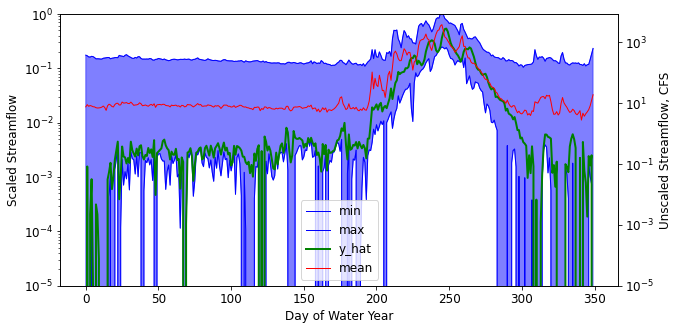

In [39]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

ax.plot(y_sims.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims.T.min(axis=1), y_sims.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0+0.00001,1)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_yscale('log')
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_full_space_emulated_logscale.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_full_space_emulated_logscale.eps', format='eps')
plt.show()


#### Run Forward Simulations from params_1

In [40]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')
    
y_sims_params_1 = genSimulation(DataX_test, params_1, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



#### Plot time series (from params_1)

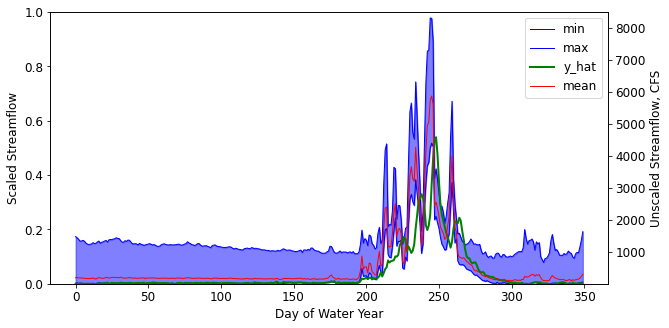

In [41]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

ax.plot(y_sims_params_1.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_params_1.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims_params_1.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims_params_1.T.min(axis=1), y_sims_params_1.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_params_1_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_params_1_emulated.eps', format='eps')
plt.show()


#### Plot time series (from params 1)

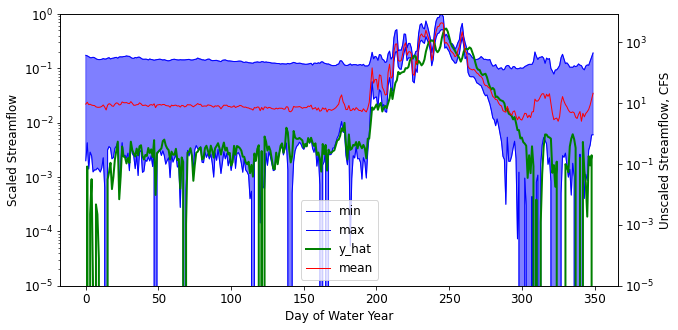

In [42]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

ax.plot(y_sims_params_1.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_params_1.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims_params_1.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims_params_1.T.min(axis=1), y_sims_params_1.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0+0.00001,1)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_yscale('log')
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_params_1_emulated_logscale.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_params_1_emulated_logscale.eps', format='eps')
plt.show()


#### Plot compressed version of time series, param 1

In [43]:
# plot
receipt_arr_p1 = torch.empty((y_sims_params_1.shape[0], stat_typ.shape[0]))
for re_i in range(receipt_arr_p1.shape[0]):
    receipt_arr_p1[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_1[re_i]), stat_typ))


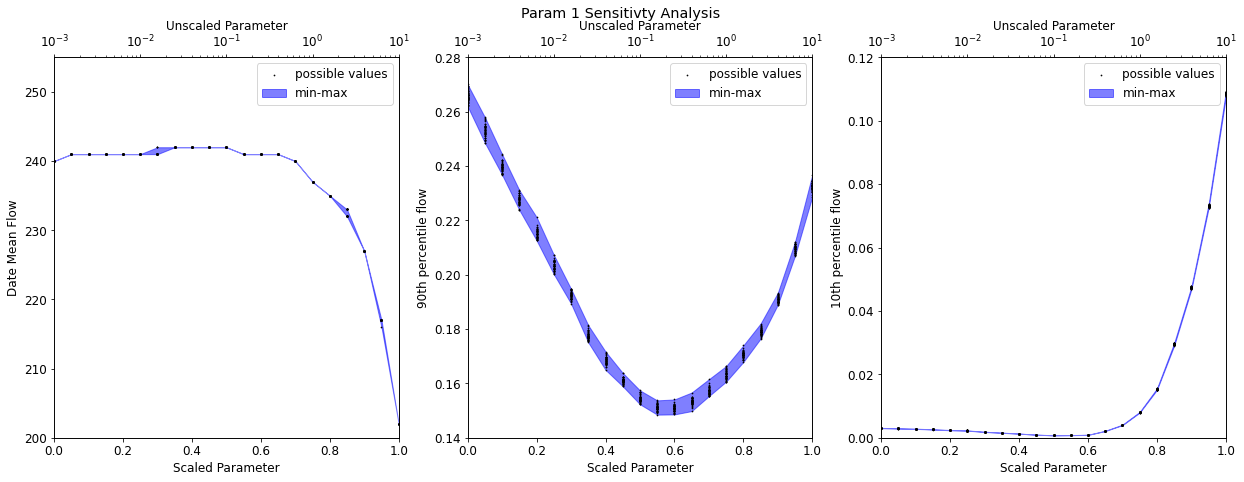

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax2 = copy(ax)
for ax_i in range(len(ax)):
    ax2[ax_i] = ax[ax_i].twiny()
    
    
# ax2 = ax.twinx()
suptitle = 'Param 1 Sensitivty Analysis'
label_list = ['Date Mean Flow', '90th percentile flow', '10th percentile flow']
y_lims_l = [(200, 255), (0.14, 0.28), (0.00, 0.12)]
for stat_i in range(len(stat_typ)):
    plot_arr = torch.empty(len(params_1[:,0]),2)
    plot_arr[:,0] = params_1[:,0]
    plot_arr[:,1] = receipt_arr_p1[:, stat_i]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plot shit
    ax[stat_i].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[stat_i].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[stat_i].set_ylabel(label_list[stat_i])
    ax[stat_i].set_ylim(y_lims_l[stat_i])
    ax[stat_i].set_xlabel('Scaled Parameter')
    ax[stat_i].set_xlim(0,1)
    ax[stat_i].legend()

    ax2[stat_i].set_xlim(10**(AOC1_Min), 10**AOC1_Max)
    ax2[stat_i].set_xscale('log')
    ax2[stat_i].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_sensitivity_{sub}_params_1_emulated.png')
fig.savefig(f'{save_dir}streamflow_sensitiivty_{sub}_params_1_emulated.eps', format='eps')
plt.show()
    

#### Generate true simulations (param_1)

In [45]:
# metric_arr
metric_arr = torch.empty((y_sims_params_1.shape[0],17)) # this is storing everything for obj_mets.calcualte_all_functions
y_sims_params_1.shape

(1050, 350)

In [46]:
# for each parameter pair
h = 0
for h in range(len(y_sims_params_1)):
    y_test = y_sims_params_1[h,:]
    parma = params_1[h,:]
    parma = parma[None, :]
    # generate y_true
    y_true = genSimulation(DataX_test, parma, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:]
    met_temp = torch.tensor(np.array(obj_mets.calculate_all_functions(y_true,y_test))[:,1].astype(float))
    metric_arr[h,:] = met_temp
    h = h + 1
    
    del y_test, parma, y_true, met_temp

/home/qh8373/.local/lib/python3.8/site-packages/spotpy/objectivefunctions.py:128: RuntimeWarning: invalid value encountered in log
  return float(1 - sum((np.log(s) - np.log(e))**2) / sum((np.log(e) - np.mean(np.log(e)))**2))


#### Plot Stuff

(2, 4)


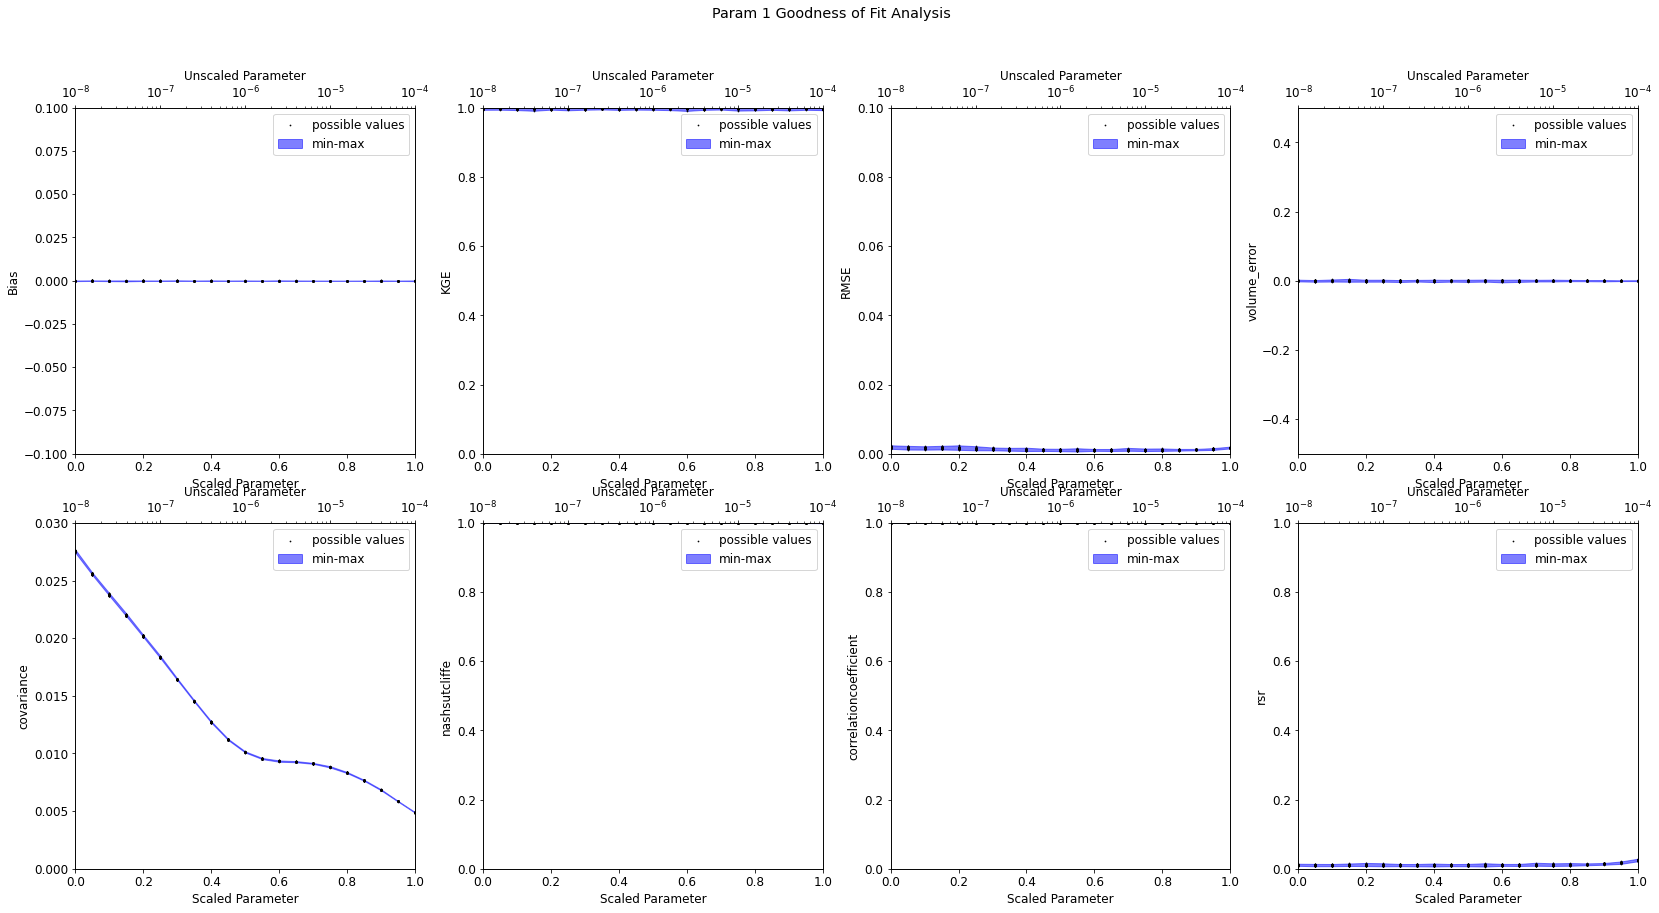

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(28, 14))

ax2 = copy(ax)
print(ax2.shape)
for ax_i in range(len(ax)):
    for ax_l in range(len(ax[ax_i])):
        ax2[ax_i][ax_l] = ax[ax_i][ax_l].twiny()

suptitle = 'Param 1 Goodness of Fit Analysis'
label_list = ['Bias', 'KGE', 'RMSE', 'volume_error', 'covariance', 'nashsutcliffe', 'correlationcoefficient', 'rsr']
label_idx =  [1,        5,      12,        16,           3,             10,            2,                        15]
ys_lim    =  [[-0.1, 0.1], [0, 1], [0, 0.1], [-0.5, 0.5], [0, 0.03], [0, 1], [0, 1], [0, 1]]


for stat_i in range(len(label_list)):
    plot_arr = torch.empty(len(params_1[:,0]),2)
    plot_arr[:,0] = params_1[:,0]
    plot_arr[:,1] = metric_arr[:, label_idx[stat_i]]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plotting indexes
    if stat_i < 4:
        plot_i = 0
    else:
        plot_i = 1
    plot_j = stat_i%4
    
    # plot shit
    ax[plot_i, plot_j].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[plot_i, plot_j].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[plot_i, plot_j].set_ylim(ys_lim[stat_i])
    ax[plot_i, plot_j].set_ylabel(label_list[stat_i])
    ax[plot_i, plot_j].set_xlabel('Scaled Parameter')
    ax[plot_i, plot_j].set_xlim(0,1)
    ax[plot_i, plot_j].legend()

    ax2[plot_i, plot_j].set_xlim(10**(AOC2_Min), 10**AOC2_Max)
    ax2[plot_i, plot_j].set_xscale('log')
    ax2[plot_i, plot_j].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr, plot_i, plot_j

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_params_1_emulated_baseline.png')
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_params_1_emulated_baseline.eps', format='eps')
plt.show()

#### Run Forward Simulations from params_2

In [50]:
# generate forward simulations
if len(lstm_out_list) > 1:
    print('Caution, multiple emulators available')
    

# y_sims_PF = genSimulation(DataX_test, boots_params_PF, lstm_out_list, lstm_idx=lstm_idx, y_len=y_len)
y_sims_params_2 = genSimulation(DataX_test, params_2, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)



#### Plot time series (from params_2)

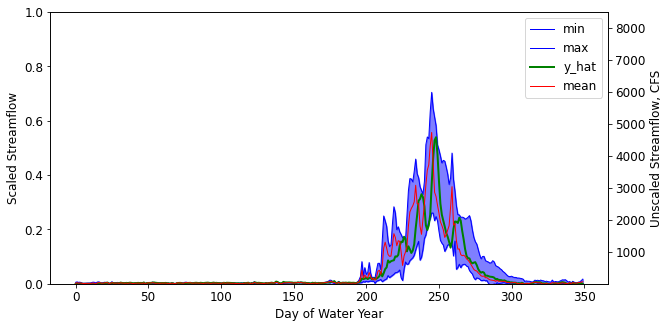

In [51]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

ax.plot(y_sims_params_2.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_params_2.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims_params_2.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims_params_2.T.min(axis=1), y_sims_params_2.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0,1)
ax.legend()
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_params_2_emulated.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_params_2_emulated.eps', format='eps')
plt.show()


#### Plot time series (from params 2)

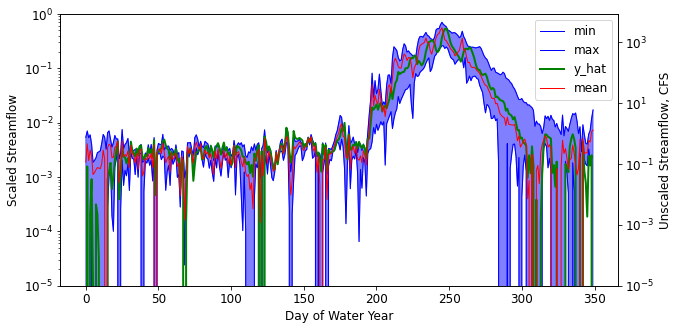

In [52]:
x = np.linspace(0,len(y_hat_plot)-1, len(y_hat_plot))

fig, ax = plt.subplots(figsize=(10, 5))
sub_sub = "{:02d}".format(idx)

ax.plot(y_sims_params_2.T.min(axis=1), color='blue', linewidth=1, zorder=0, label='min')
ax.plot(y_sims_params_2.T.max(axis=1), color='blue', linewidth=1, zorder=0, label='max')
ax.plot(y_hat_plot, color='green', linewidth=2, label='y_hat', zorder=1)
ax.plot(np.mean(y_sims_params_2.T,axis=1), color='red', linewidth=1, label='mean', zorder=2)
ax.fill_between(x, y_sims_params_2.T.min(axis=1), y_sims_params_2.T.max(axis=1), color='blue', zorder=0, alpha=0.5)

ax.set_ylim(0+0.00001,1)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Scaled Streamflow')
ax.set_xlabel('Day of Water Year')

ax2 = ax.twinx()
ax2.set_ylim(Q_min+0.00001,Q_max)
ax2.set_yscale('log')
ax2.set_ylabel('Unscaled Streamflow, CFS')

fig.savefig(f'{save_dir}streamflow_series_{sub}_params_2_emulated_logscale.png')
fig.savefig(f'{save_dir}streamflow_series_{sub}_params_2_emulated_logscale.eps', format='eps')
plt.show()


In [53]:
# plot
receipt_arr_p2 = torch.empty((y_sims_params_2.shape[0], stat_typ.shape[0]))
for re_i in range(receipt_arr_p2.shape[0]):
    receipt_arr_p2[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_2[re_i]), stat_typ))

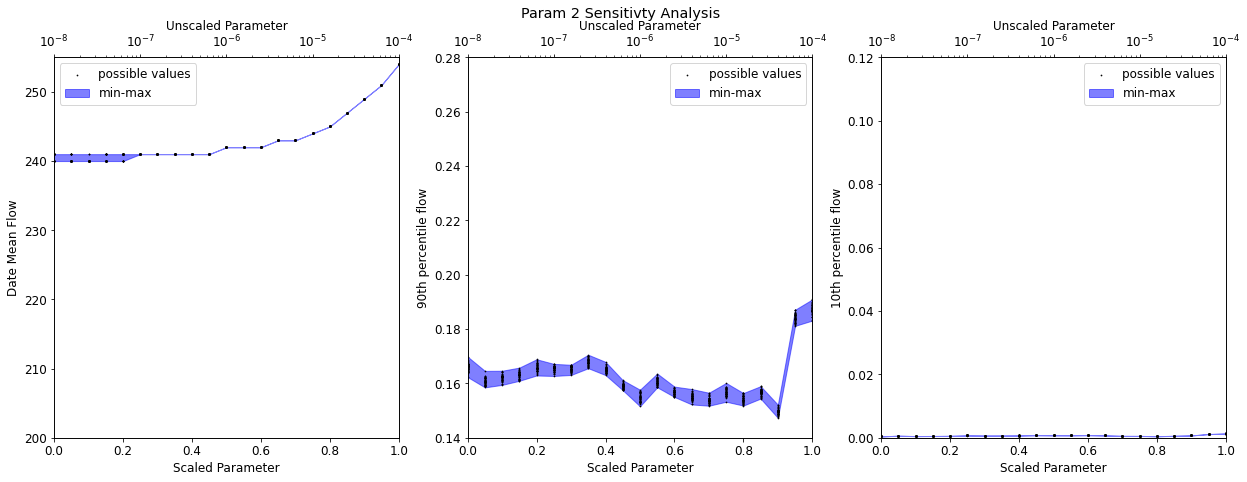

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax2 = copy(ax)
for ax_i in range(len(ax)):
    ax2[ax_i] = ax[ax_i].twiny()
    
# ax2 = ax.twinx()
suptitle = 'Param 2 Sensitivty Analysis'
label_list = ['Date Mean Flow', '90th percentile flow', '10th percentile flow']
y_lims_l = [(200, 255), (0.14, 0.28), (0.00, 0.12)]
for stat_i in range(len(stat_typ)):
    plot_arr = torch.empty(len(params_2[:,1]),2)
    plot_arr[:,0] = params_2[:,1]
    plot_arr[:,1] = receipt_arr_p2[:, stat_i]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plot shit
    ax[stat_i].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[stat_i].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[stat_i].set_ylim(y_lims_l[stat_i])
    ax[stat_i].set_ylabel(label_list[stat_i])
    ax[stat_i].set_xlabel('Scaled Parameter')
    ax[stat_i].set_xlim(0,1)
    ax[stat_i].legend()

    ax2[stat_i].set_xlim(10**(AOC2_Min), 10**AOC2_Max)
    ax2[stat_i].set_xscale('log')
    ax2[stat_i].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_sensitivity_{sub}_params_2_emulated.png')
fig.savefig(f'{save_dir}streamflow_sensitiivty_{sub}_params_2_emulated.eps', format='eps')
plt.show()
    

#### Generate true simulations

In [55]:
# metric_arr
metric_arr = torch.empty((y_sims_params_2.shape[0],17)) # this is storing everything for obj_mets.calcualte_all_functions

In [56]:
# for each parameter pair, get metrics
h = 0
for h in range(len(y_sims_params_2)):
    y_test = y_sims_params_2[h,:]
    parma = params_2[h,:]
    parma = parma[None, :]
    # generate y_true
    y_true = genSimulation(DataX_test, parma, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:]
    met_temp = torch.tensor(np.array(obj_mets.calculate_all_functions(y_true,y_test))[:,1].astype(float))
    metric_arr[h,:] = met_temp
    h = h + 1
    
    del y_test, parma, y_true, met_temp

/home/qh8373/.local/lib/python3.8/site-packages/spotpy/objectivefunctions.py:128: RuntimeWarning: invalid value encountered in log
  return float(1 - sum((np.log(s) - np.log(e))**2) / sum((np.log(e) - np.mean(np.log(e)))**2))


#### Plot Stuff

(2, 4)


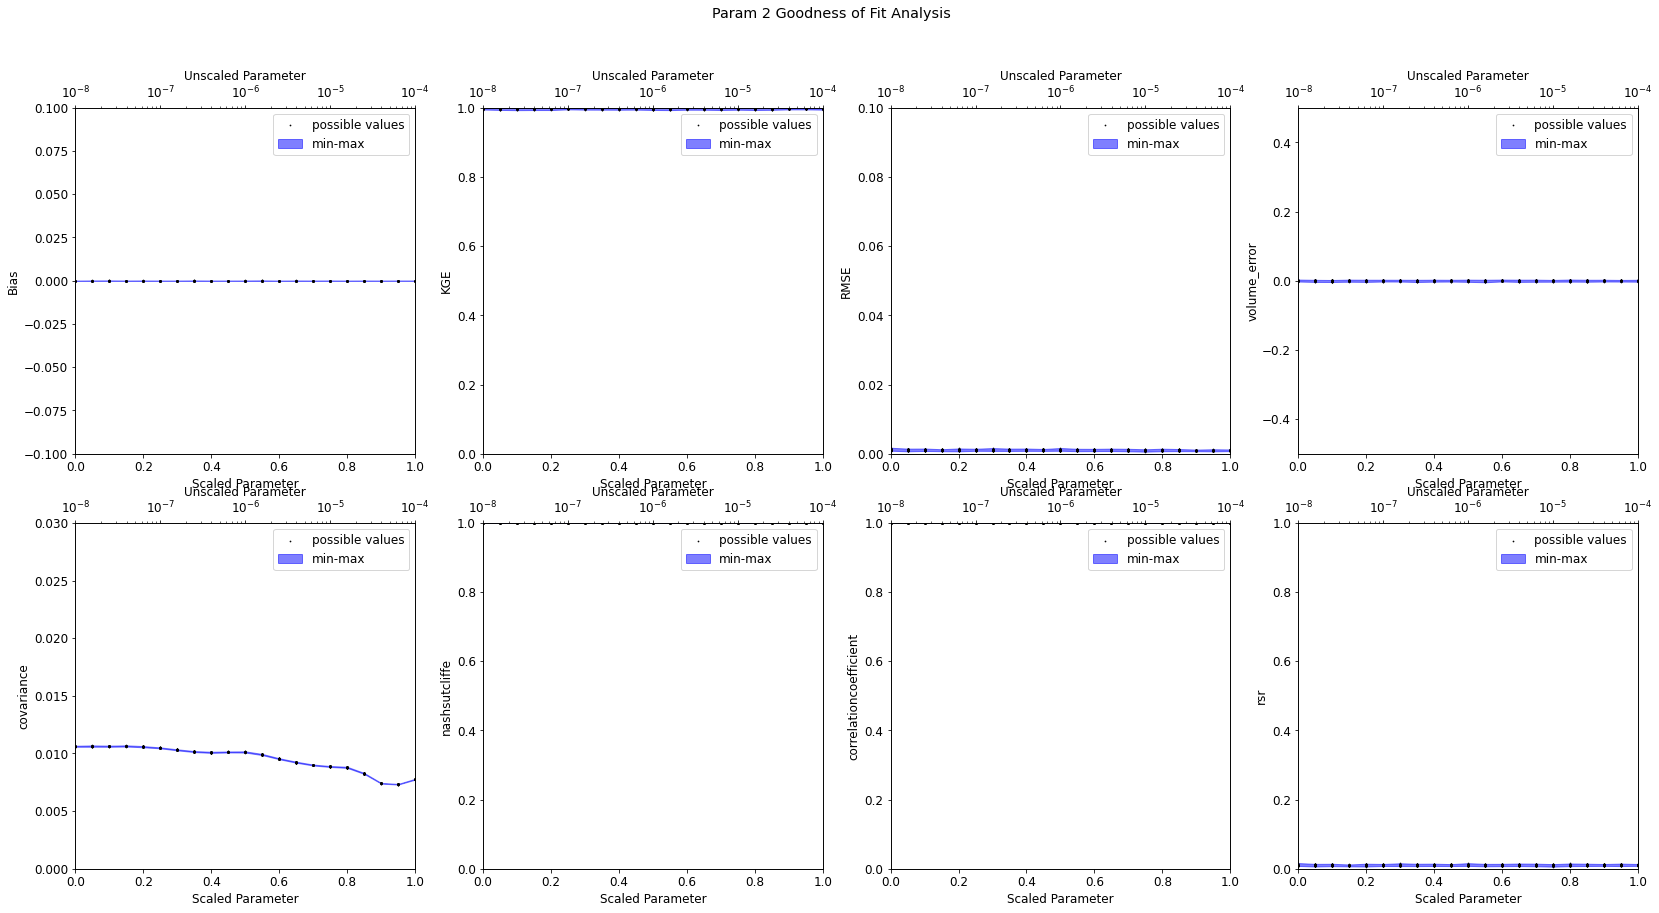

In [57]:
fig, ax = plt.subplots(2, 4, figsize=(28, 14))

ax2 = copy(ax)
print(ax2.shape)
for ax_i in range(len(ax)):
    for ax_l in range(len(ax[ax_i])):
        ax2[ax_i][ax_l] = ax[ax_i][ax_l].twiny()

    

suptitle = 'Param 2 Goodness of Fit Analysis'
label_list = ['Bias', 'KGE', 'RMSE', 'volume_error', 'covariance', 'nashsutcliffe', 'correlationcoefficient', 'rsr']
label_idx =  [1,        5,      12,        16,           3,             10,            2,                        15]
ys_lim    =  [[-0.1, 0.1], [0, 1], [0, 0.1], [-0.5, 0.5], [0, 0.03], [0, 1], [0, 1], [0, 1]]
    

for stat_i in range(len(label_list)):
    plot_arr = torch.empty(len(params_2[:,1]),2)
    plot_arr[:,0] = params_2[:,1]
    plot_arr[:,1] = metric_arr[:, label_idx[stat_i]]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plotting indexes
    if stat_i < 4:
        plot_i = 0
    else:
        plot_i = 1
    plot_j = stat_i%4
    
    # plot shit
    ax[plot_i, plot_j].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[plot_i, plot_j].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[plot_i, plot_j].set_ylim(ys_lim[stat_i])
    ax[plot_i, plot_j].set_ylabel(label_list[stat_i])
    ax[plot_i, plot_j].set_xlabel('Scaled Parameter')
    ax[plot_i, plot_j].set_xlim(0,1)
    ax[plot_i, plot_j].legend()

    ax2[plot_i, plot_j].set_xlim(10**(AOC2_Min), 10**AOC2_Max)
    ax2[plot_i, plot_j].set_xscale('log')
    ax2[plot_i, plot_j].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr, plot_i, plot_j

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_params_2_emulated_baseline.png')
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_params_2_emulated_baseline.eps', format='eps')
plt.show()

### Do Inference (Params 1)
* Select True Params
* Gen Forward Simulations
* Do Inference
* Bootstrap 50 param pairs
    * PLot Scatter of Params
* Run Forward on bootstrap
    * Plot Scatter of Metrics

In [58]:
# Select True Params
params_1_sub = params_1[:num_sample,:]

In [59]:
params_1_sub_dupe = torch.empty(params_1.shape)
for mli in range(len(params_1_sub[:,0])):
    params_1_sub_dupe[int((mli)*50):int((mli+1)*50),] = params_1_sub[mli,:]

In [60]:
# Gen Forward Simulations
y_true_params_1_sub = genSimulation(DataX_test, params_1_sub, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)

In [61]:
params_1_full = torch.empty(params_1.shape)

# Do inference
for l in range(num_sample): 
    # emulated
    y_hat_temp = y_true_params_1_sub[l,:]
    params_1_sub_true = params_1_sub[l,:]
    
    # - given observation(s), sample posterior, evaluate probability, and plot
    posterior_samples_temp = posterior.sample((n_samples,), x=y_hat_temp, show_progress_bars=False) # type - tensor object
    # posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
    log_probability_temp = posterior.log_prob(posterior_samples_temp, x=y_hat_temp).unsqueeze(1) # type - tensor object

    # Bootstrap
    boots_params_temp, boots_logprob_temp, idxs_temp = randBootstrap(posterior_samples_temp, log_probability_temp)
    
    # Save for later
    params_1_full[int((l)*50):int((l+1)*50), :] = boots_params_temp

    
    del y_hat_temp, params_1_sub_true, posterior_samples_temp, log_probability_temp
    del boots_params_temp, boots_logprob_temp, idxs_temp

#### Plot Scatter of Params (1)

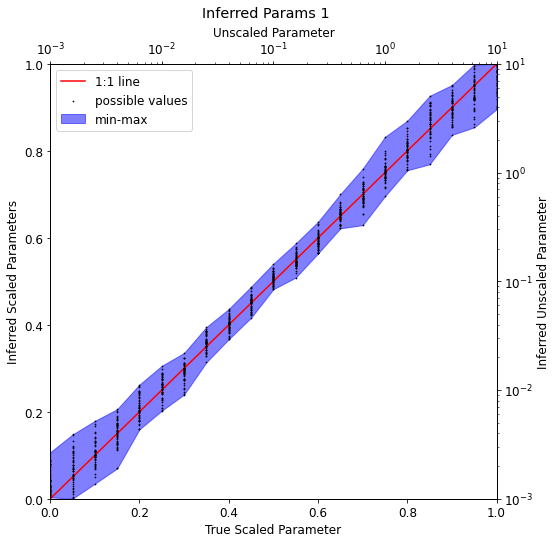

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))

suptitle = 'Inferred Params 1'

#extract minmax
min_max_arr = torch.empty((len(torch.unique(params_1_sub_dupe[:,0])), 2))
j = 0
for idxs in torch.unique(params_1_sub_dupe[:,0]):
    min_max_arr[j, :] = torch.tensor((params_1_full[:,0][params_1_sub_dupe[:,0]==idxs].min(), params_1_full[:,0][params_1_sub_dupe[:,0]==idxs].max()))
    j = j + 1

# plot shit
ax.scatter(params_1_sub_dupe[:,0], params_1_full[:,0],s=0.5, color='black', zorder=2, label='possible values')
ax.fill_between(torch.unique(params_1_sub_dupe[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
ax.plot([0,1], [0,1], color='red', zorder=1, label='1:1 line')

ax.set_ylabel('Inferred Scaled Parameters')
ax.set_ylim(0,1)
ax.set_xlabel('True Scaled Parameter')
ax.set_xlim(0,1)
ax.legend()

ax2 = ax.twinx()
ax3 = ax.twiny()

ax2.set_ylim(10**(AOC1_Min), 10**AOC1_Max)
ax2.set_yscale('log')
ax2.set_ylabel('Inferred Unscaled Parameter')

ax3.set_xlim(10**(AOC1_Min), 10**AOC1_Max)
ax3.set_xscale('log')
ax3.set_xlabel('Unscaled Parameter')



plt.suptitle(suptitle)
fig.savefig(f'{save_dir}inferred_parameters_{sub}_params_1_emulated.png')
fig.savefig(f'{save_dir}inferred_parameters_{sub}_params_1_emulated.eps', format='eps')
plt.show()

#### Generate true simulations (param_1) - for metrics

In [63]:
# metric_arr
metric_arr = torch.empty((params_1_full.shape[0],17)) # this is storing everything for obj_mets.calcualte_all_functions
y_sims_params_1_inf = torch.empty((params_1_full.shape[0],350))

In [64]:
# for each parameter pair
h = 0
for h in range(len(params_1_full)):

    # test parameter sets (inferred)
    parma_test = params_1_full[h,:]
    parma_test = parma_test[None, :]

    # train parameter sets (true)
    parma_true = params_1_sub_dupe[h,:]
    parma_true = parma_true[None, :]
    
    # generate y_test
    y_test = genSimulation(DataX_test, parma_test, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:] 

    # generate y_true
    y_true = genSimulation(DataX_test, parma_true, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:]
    
    y_sims_params_1_inf[h,:] = torch.tensor(y_test)
    met_temp = torch.tensor(np.array(obj_mets.calculate_all_functions(y_true,y_test))[:,1].astype(float))
    metric_arr[h,:] = met_temp
    h = h + 1
    
    del y_test, parma_test, parma_true, y_true, met_temp

### SF Stats

In [65]:
# plot
receipt_arr_p1_inf = torch.empty((params_1_full.shape[0], stat_typ.shape[0]))
for re_i in range(receipt_arr_p1_inf.shape[0]):
    receipt_arr_p1_inf[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_1_inf[re_i]), stat_typ))

<ipython-input-65-96f06e92905f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  receipt_arr_p1_inf[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_1_inf[re_i]), stat_typ))


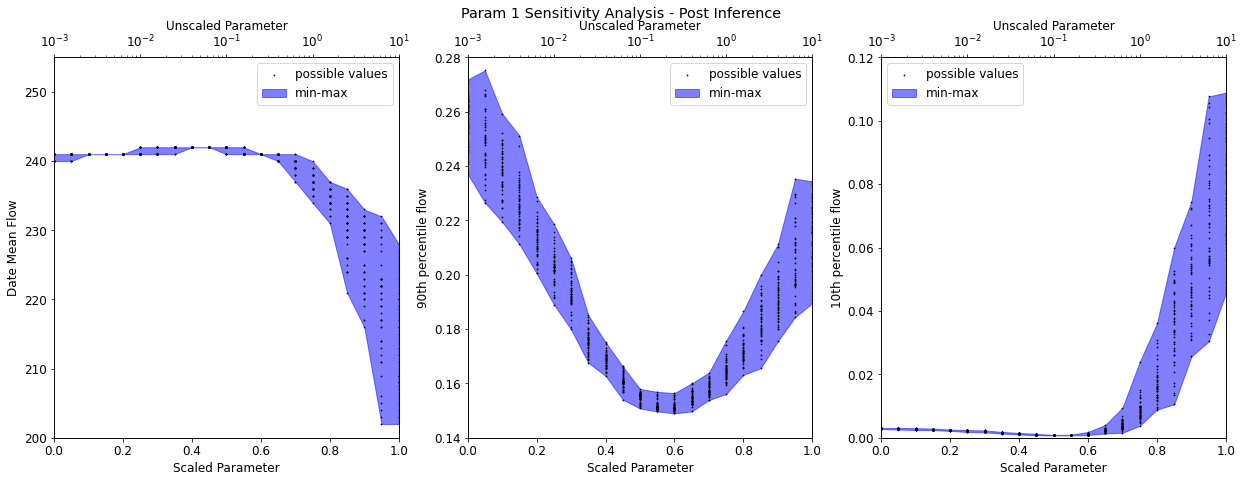

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax2 = copy(ax)
for ax_i in range(len(ax)):
    ax2[ax_i] = ax[ax_i].twiny()
    
# ax2 = ax.twinx()
suptitle = 'Param 1 Sensitivity Analysis - Post Inference'
label_list = ['Date Mean Flow', '90th percentile flow', '10th percentile flow']
y_lims_l = [(200, 255), (0.14, 0.28), (0.00, 0.12)]
for stat_i in range(len(stat_typ)):
    plot_arr = torch.empty(len(params_1_sub_dupe[:,0]),2)
    plot_arr[:,0] = params_1_sub_dupe[:,0]
    plot_arr[:,1] = receipt_arr_p1_inf[:, stat_i]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plot shit
    ax[stat_i].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[stat_i].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[stat_i].set_ylim(y_lims_l[stat_i])
    ax[stat_i].set_ylabel(label_list[stat_i])
    ax[stat_i].set_xlabel('Scaled Parameter')
    ax[stat_i].set_xlim(0,1)
    ax[stat_i].legend()

    ax2[stat_i].set_xlim(10**(AOC1_Min), 10**AOC1_Max)
    ax2[stat_i].set_xscale('log')
    ax2[stat_i].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_sensitivity_inference_{sub}_inferred_params_1_emulated.png')
fig.savefig(f'{save_dir}streamflow_sensitiivty_inference_{sub}_inferred_params_1_emulated.eps', format='eps')
plt.show()
    

#### Plot Stuff (param 1) - for metrics

(2, 4)


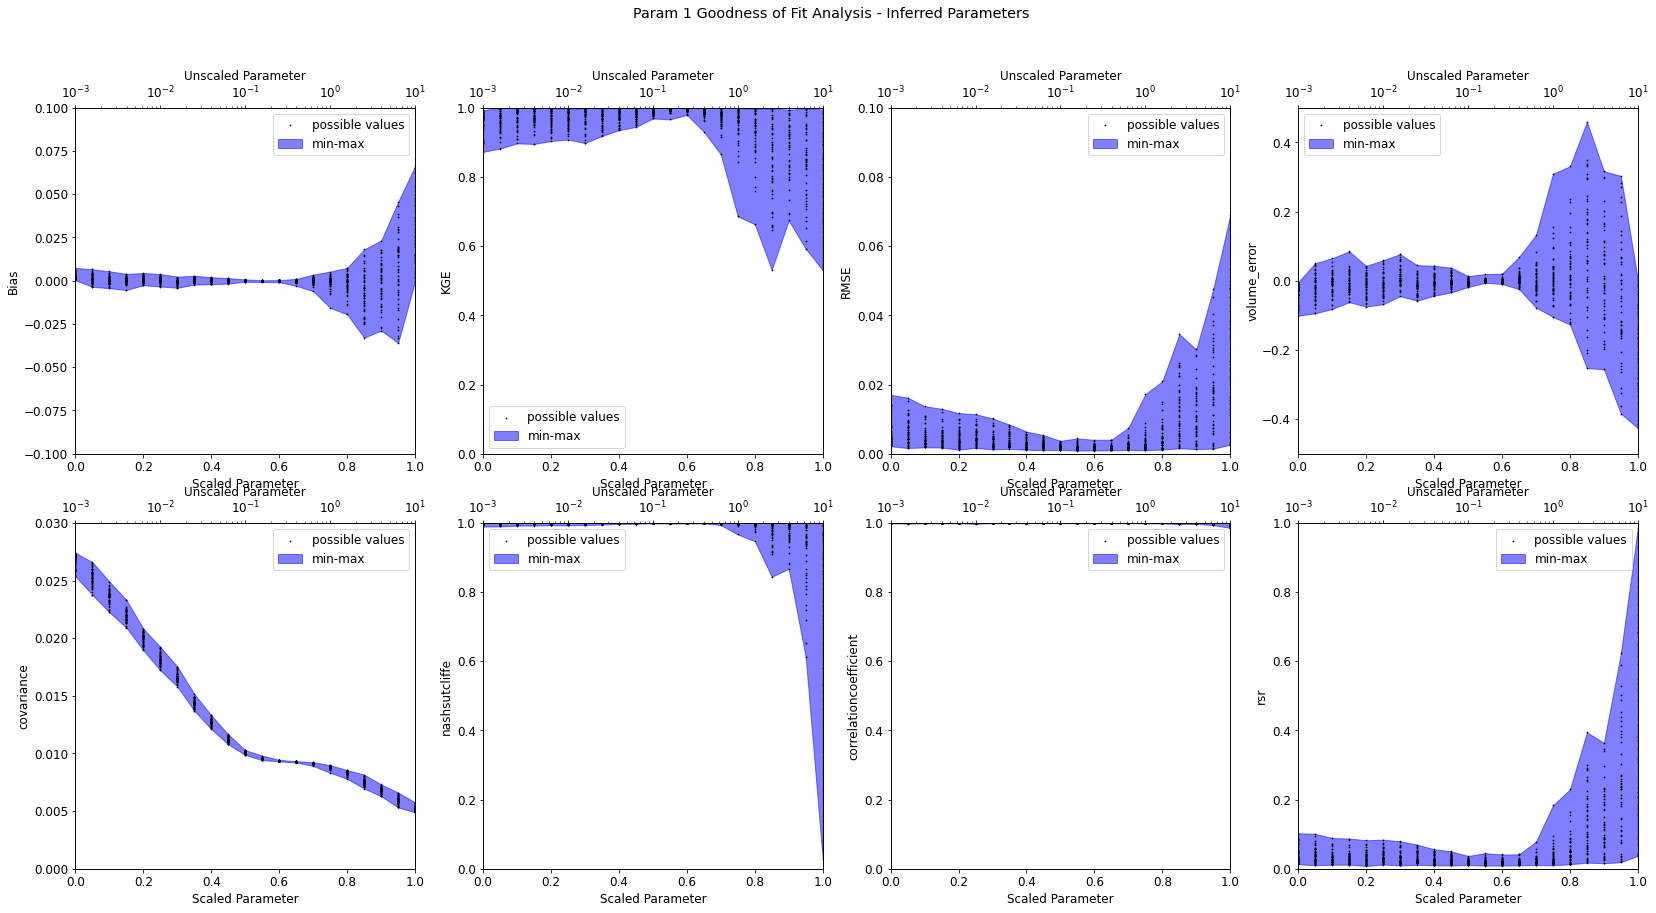

In [67]:
fig, ax = plt.subplots(2, 4, figsize=(28, 14))

ax2 = copy(ax)
print(ax2.shape)
for ax_i in range(len(ax)):
    for ax_l in range(len(ax[ax_i])):
        ax2[ax_i][ax_l] = ax[ax_i][ax_l].twiny()

suptitle = 'Param 1 Goodness of Fit Analysis - Inferred Parameters'
label_list = ['Bias', 'KGE', 'RMSE', 'volume_error', 'covariance', 'nashsutcliffe', 'correlationcoefficient', 'rsr']
label_idx =  [1,        5,      12,        16,           3,             10,            2,                        15]
ys_lim    =  [[-0.1, 0.1], [0, 1], [0, 0.1], [-0.5, 0.5], [0, 0.03], [0, 1], [0, 1], [0, 1]]

for stat_i in range(len(label_list)):
    plot_arr = torch.empty(len(params_1_sub_dupe[:,0]),2)
    plot_arr[:,0] = params_1_sub_dupe[:,0]
    plot_arr[:,1] = metric_arr[:, label_idx[stat_i]]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plotting indexes
    if stat_i < 4:
        plot_i = 0
    else:
        plot_i = 1
    plot_j = stat_i%4
    
    # plot shit
    ax[plot_i, plot_j].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[plot_i, plot_j].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[plot_i, plot_j].set_ylim(ys_lim[stat_i])
    ax[plot_i, plot_j].set_ylabel(label_list[stat_i])
    ax[plot_i, plot_j].set_xlabel('Scaled Parameter')
    ax[plot_i, plot_j].set_xlim(0,1)
    ax[plot_i, plot_j].legend()

    ax2[plot_i, plot_j].set_xlim(10**(AOC1_Min), 10**AOC1_Max)
    ax2[plot_i, plot_j].set_xscale('log')
    ax2[plot_i, plot_j].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr, plot_i, plot_j

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_inferred_params_1_emulated_baseline.png')
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_inferred_params_1_emulated_baseline.eps', format='eps')
plt.show()

### Do Inference (Params 2)
* Select True Params
* Gen Forward Simulations
* Do Inference
* Bootstrap 50 param pairs
    * PLot Scatter of Params
* Run Forward on bootstrap
    * Plot Scatter of Metrics

In [68]:
# Select True Params
params_2_sub = params_2[:num_sample,:]

In [69]:
params_2_sub_dupe = torch.empty(params_2.shape)
for mli in range(len(params_2_sub[:,0])):
    params_2_sub_dupe[int((mli)*50):int((mli+1)*50),] = params_2_sub[mli,:]

In [70]:
# Gen Forward Simulations
y_true_params_2_sub = genSimulation(DataX_test, params_2_sub, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)

In [71]:
params_2_full = torch.empty(params_2.shape)

# Do inference
for l in range(num_sample): 
    # emulated
    y_hat_temp = y_true_params_2_sub[l,:]
    params_2_sub_true = params_2_sub[l,:]
    
    # - given observation(s), sample posterior, evaluate probability, and plot
    posterior_samples_temp = posterior.sample((n_samples,), x=y_hat_temp, show_progress_bars=False) # type - tensor object
    # posterior_samples_simulations = bulk_simulate(posterior_samples, num_days, n_samples, ensemble_path, model_path)
    log_probability_temp = posterior.log_prob(posterior_samples_temp, x=y_hat_temp).unsqueeze(1) # type - tensor object

    # Bootstrap
    boots_params_temp, boots_logprob_temp, idxs_temp = randBootstrap(posterior_samples_temp, log_probability_temp)
    
    # Save for later
    params_2_full[int((l)*50):int((l+1)*50), :] = boots_params_temp

    
    del y_hat_temp, params_2_sub_true, posterior_samples_temp, log_probability_temp
    del boots_params_temp, boots_logprob_temp, idxs_temp

#### Plot Scatter of Params (2)

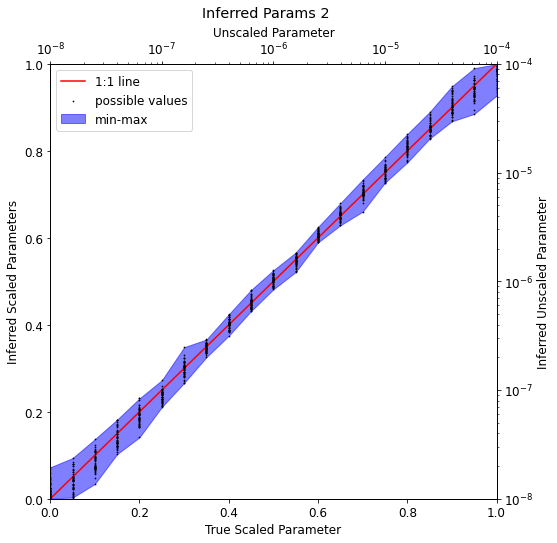

In [72]:
fig, ax = plt.subplots(figsize=(8, 8))

suptitle = 'Inferred Params 2'

#extract minmax
min_max_arr = torch.empty((len(torch.unique(params_2_sub_dupe[:,1])), 2))
j = 0
for idxs in torch.unique(params_2_sub_dupe[:,1]):
    min_max_arr[j, :] = torch.tensor((params_2_full[:,1][params_2_sub_dupe[:,1]==idxs].min(), params_2_full[:,1][params_2_sub_dupe[:,1]==idxs].max()))
    j = j + 1

# plot shit
ax.scatter(params_2_sub_dupe[:,1], params_2_full[:,1],s=0.5, color='black', zorder=2, label='possible values')
ax.fill_between(torch.unique(params_2_sub_dupe[:,1]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
ax.plot([0,1], [0,1], color='red', zorder=1, label='1:1 line')

ax.set_ylabel('Inferred Scaled Parameters')
ax.set_ylim(0,1)
ax.set_xlabel('True Scaled Parameter')
ax.set_xlim(0,1)
ax.legend()

ax2 = ax.twinx()
ax3 = ax.twiny()

ax2.set_ylim(10**(AOC2_Min), 10**AOC2_Max)
ax2.set_yscale('log')
ax2.set_ylabel('Inferred Unscaled Parameter')

ax3.set_xlim(10**(AOC2_Min), 10**AOC2_Max)
ax3.set_xscale('log')
ax3.set_xlabel('Unscaled Parameter')



plt.suptitle(suptitle)
fig.savefig(f'{save_dir}inferred_parameters_{sub}_params_2_emulated.png')
fig.savefig(f'{save_dir}inferred_parameters_{sub}_params_2_emulated.eps', format='eps')
plt.show()
    

    

#### Generate true simulations (param_2) - for metrics

In [73]:
# metric_arr
metric_arr = torch.empty((params_2_full.shape[0],17)) # this is storing everything for obj_mets.calcualte_all_functions
y_sims_params_2_inf = torch.empty((params_2_full.shape[0],350))


In [74]:
# for each parameter pair
h = 0
for h in range(len(params_2_full)):

    # test parameter sets (inferred)
    parma_test = params_2_full[h,:]
    parma_test = parma_test[None, :]

    # train parameter sets (true)
    parma_true = params_2_sub_dupe[h,:]
    parma_true = parma_true[None, :]
    
    # generate y_test
    y_test = genSimulation(DataX_test, parma_test, lstm_out_list,
                       add_noise=True,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:] 

    # generate y_true
    y_true = genSimulation(DataX_test, parma_true, lstm_out_list,
                       add_noise=False,f_noise=1e-2,lstm_idx=lstm_idx, y_len=y_len)[0,:]

    y_sims_params_2_inf[h,:] = torch.tensor(y_test)
    met_temp = torch.tensor(np.array(obj_mets.calculate_all_functions(y_true,y_test))[:,1].astype(float))
    metric_arr[h,:] = met_temp
    h = h + 1
    
    del y_test, parma_test, parma_true, y_true, met_temp

### SF Stats

In [75]:
# plot
receipt_arr_p2_inf = torch.empty((params_2_full.shape[0], stat_typ.shape[0]))
for re_i in range(receipt_arr_p2_inf.shape[0]):
    receipt_arr_p2_inf[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_2_inf[re_i]), stat_typ))

<ipython-input-75-17057943db35>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  receipt_arr_p2_inf[re_i, :] = torch.tensor(setStatSim(torch.tensor(y_sims_params_2_inf[re_i]), stat_typ))


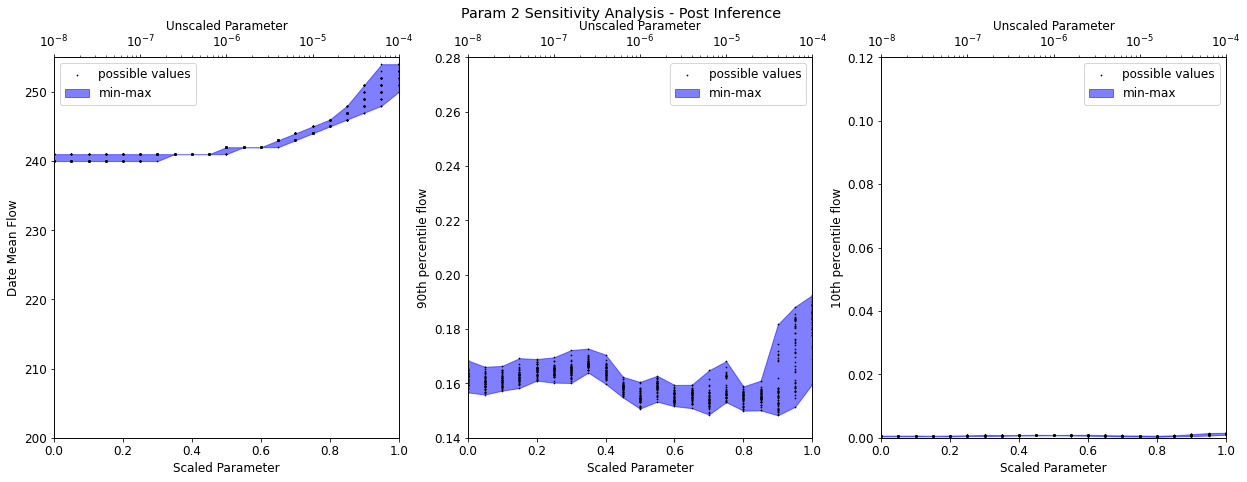

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax2 = copy(ax)
for ax_i in range(len(ax)):
    ax2[ax_i] = ax[ax_i].twiny()
    
# ax2 = ax.twinx()
suptitle = 'Param 2 Sensitivity Analysis - Post Inference'
label_list = ['Date Mean Flow', '90th percentile flow', '10th percentile flow']
y_lims_l = [(200, 255), (0.14, 0.28), (0.00, 0.12)]
for stat_i in range(len(stat_typ)):
    plot_arr = torch.empty(len(params_2_sub_dupe[:,1]),2)
    plot_arr[:,0] = params_2_sub_dupe[:,1]
    plot_arr[:,1] = receipt_arr_p2_inf[:, stat_i]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plot shit
    ax[stat_i].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[stat_i].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[stat_i].set_ylim(y_lims_l[stat_i])
    ax[stat_i].set_ylabel(label_list[stat_i])
    ax[stat_i].set_xlabel('Scaled Parameter')
    ax[stat_i].set_xlim(0,1)
    ax[stat_i].legend()

    ax2[stat_i].set_xlim(10**(AOC2_Min), 10**AOC2_Max)
    ax2[stat_i].set_xscale('log')
    ax2[stat_i].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_sensitivity_inference_{sub}_inferred_params_2_emulated.png')
fig.savefig(f'{save_dir}streamflow_sensitiivty_inference_{sub}_inferred_params_2_emulated.eps', format='eps')
plt.show()
    

#### Plot Stuff (param 2) - for metrics

(2, 4)


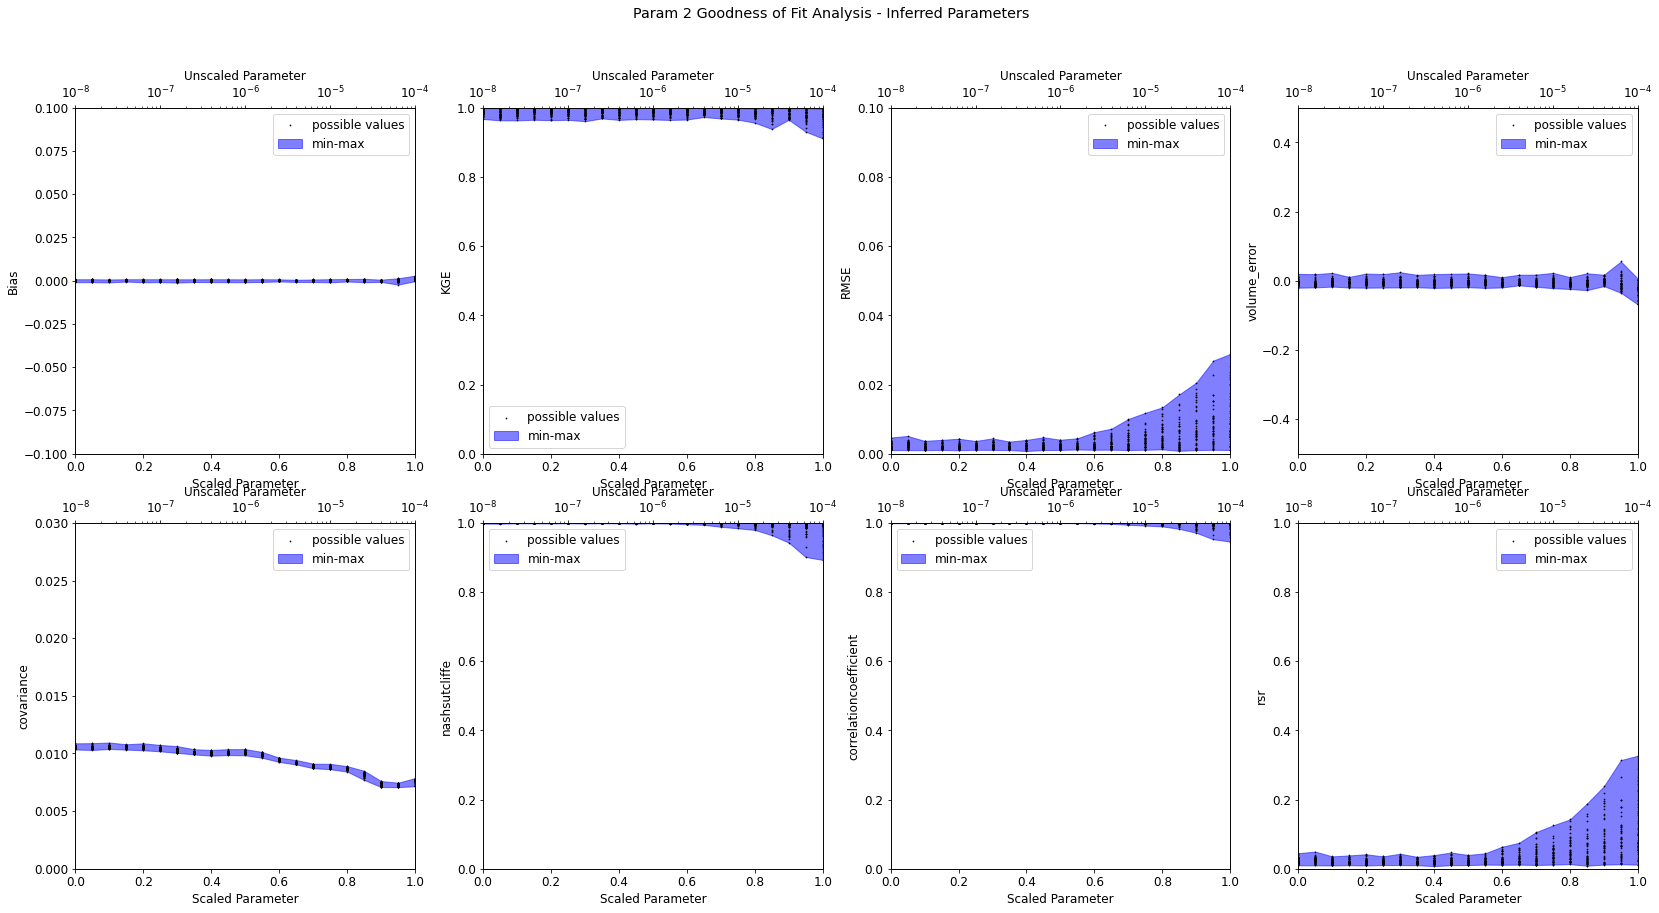

In [77]:
fig, ax = plt.subplots(2, 4, figsize=(28, 14))

ax2 = copy(ax)
print(ax2.shape)
for ax_i in range(len(ax)):
    for ax_l in range(len(ax[ax_i])):
        ax2[ax_i][ax_l] = ax[ax_i][ax_l].twiny()

suptitle = 'Param 2 Goodness of Fit Analysis - Inferred Parameters'
label_list = ['Bias', 'KGE', 'RMSE', 'volume_error', 'covariance', 'nashsutcliffe', 'correlationcoefficient', 'rsr']
label_idx =  [1,        5,      12,        16,           3,             10,            2,                        15]
ys_lim    =  [[-0.1, 0.1], [0, 1], [0, 0.1], [-0.5, 0.5], [0, 0.03], [0, 1], [0, 1], [0, 1]]

for stat_i in range(len(label_list)):
    plot_arr = torch.empty(len(params_2_sub_dupe[:,1]),2)
    plot_arr[:,0] = params_2_sub_dupe[:,1]
    plot_arr[:,1] = metric_arr[:, label_idx[stat_i]]
    
    #extract minmax
    min_max_arr = torch.empty((len(torch.unique(plot_arr[:,0])), 2))
    j = 0
    for idxs in torch.unique(plot_arr[:,0]):
        min_max_arr[j, :] = torch.tensor((plot_arr[:,1][plot_arr[:,0]==idxs].min(), plot_arr[:,1][plot_arr[:,0]==idxs].max()))
        j = j + 1

    # plotting indexes
    if stat_i < 4:
        plot_i = 0
    else:
        plot_i = 1
    plot_j = stat_i%4
    
    # plot shit
    ax[plot_i, plot_j].scatter(plot_arr[:,0], plot_arr[:,1],s=0.5, color='black', zorder=2, label='possible values')
    ax[plot_i, plot_j].fill_between(torch.unique(plot_arr[:,0]), min_max_arr[:,0], min_max_arr[:,1], color='blue', zorder=0, alpha=0.5, label='min-max')
    
    ax[plot_i, plot_j].set_ylim(ys_lim[stat_i])
    ax[plot_i, plot_j].set_ylabel(label_list[stat_i])
    ax[plot_i, plot_j].set_xlabel('Scaled Parameter')
    ax[plot_i, plot_j].set_xlim(0,1)
    ax[plot_i, plot_j].legend()

    ax2[plot_i, plot_j].set_xlim(10**(AOC2_Min), 10**AOC2_Max)
    ax2[plot_i, plot_j].set_xscale('log')
    ax2[plot_i, plot_j].set_xlabel('Unscaled Parameter')
    
    del plot_arr, j, min_max_arr, plot_i, plot_j

plt.suptitle(suptitle)
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_inferred_params_2_emulated_baseline.png')
fig.savefig(f'{save_dir}streamflow_metrics_{sub}_inferred_params_2_emulated_baseline.eps', format='eps')
plt.show()